<a href="https://colab.research.google.com/github/Siddharth-Singh-2004/CU-BEMS_multi-series_forecasting/blob/main/CU_BEMS_single_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import math

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
old_df=pd.read_csv('/content/drive/MyDrive/2018Floor1.csv')

In [6]:
old_data = {}

In [7]:
for columns in old_df.columns:
  old_data[columns] = []

In [8]:
old_data

{'Date': [],
 'z1_Light(kW)': [],
 'z1_Plug(kW)': [],
 'z2_AC1(kW)': [],
 'z2_AC2(kW)': [],
 'z2_AC3(kW)': [],
 'z2_AC4(kW)': [],
 'z2_Light(kW)': [],
 'z2_Plug(kW)': [],
 'z3_Light(kW)': [],
 'z3_Plug(kW)': [],
 'z4_Light(kW)': []}

In [9]:
for index, row in old_df.iterrows():
  if index%120 == 0:
    for columns in old_df.columns:
      old_data[columns].append(row[columns])

In [10]:
df = pd.DataFrame(old_data)

In [11]:
df['Date']=pd.to_datetime(df['Date'])

In [12]:
df.head()

,Date,z1_Light(kW),z1_Plug(kW),z2_AC1(kW),z2_AC2(kW),z2_AC3(kW),z2_AC4(kW),z2_Light(kW),z2_Plug(kW),z3_Light(kW),z3_Plug(kW),z4_Light(kW)
0,2018-07-01 00:00:00,12.94,18.56,45.24,0.01,0.01,0.00,13.76,17.64,10.92,0.89,35.76
1,2018-07-01 02:00:00,13.12,19.36,45.91,0.02,0.01,0.00,13.96,17.27,11.02,0.73,36.04
2,2018-07-01 04:00:00,12.91,18.01,45.47,0.02,0.01,0.00,13.71,10.29,10.95,0.72,35.70
3,2018-07-01 06:00:00,12.77,18.33,45.48,0.02,0.01,0.00,13.52,17.44,10.81,0.71,45.71
4,2018-07-01 08:00:00,0.01,19.18,46.09,0.00,0.01,0.01,13.79,17.70,10.98,0.75,30.69


In [13]:
df.tail()

,Date,z1_Light(kW),z1_Plug(kW),z2_AC1(kW),z2_AC2(kW),z2_AC3(kW),z2_AC4(kW),z2_Light(kW),z2_Plug(kW),z3_Light(kW),z3_Plug(kW),z4_Light(kW)
2203,2018-12-31 14:00:00,0.02,0.70,2.25,0.02,0.01,0.01,15.23,17.32,10.06,0.40,0.05
2204,2018-12-31 16:00:00,0.02,0.68,2.22,0.02,0.01,0.00,12.97,9.59,10.01,0.38,0.05
2205,2018-12-31 18:00:00,0.00,0.02,43.18,0.02,0.01,0.01,13.00,16.89,10.02,0.39,14.77
2206,2018-12-31 20:00:00,0.01,0.74,2.30,35.11,0.01,0.02,17.09,9.54,9.93,0.37,24.59
2207,2018-12-31 22:00:00,0.01,0.68,20.21,34.63,0.01,0.02,17.24,18.38,10.00,0.39,24.79


In [14]:
def clean(column):
  return column.dropna().to_numpy()

In [15]:
data = {}

In [16]:
for column in df.columns:
  if column == 'Date':
    data[column] = df[column]
  elif column == 'z1_Light(kW)':
    data[column] = clean(df[column])

In [17]:
for column in data:
  print(f'{column}: {len(df[column])}')

Date: 2208
z1_Light(kW): 2208


In [18]:
max_min = {}
for column in data:
  max_min[column] = [data[column].max(), data[column].min()]

In [19]:
# Normalizing
for column in data:
  min = max_min[column][1]
  max = max_min[column][0]
  data[column] = (data[column] - min)/(max - min)

In [20]:
# Custom Dataset
class TimeSeriesDataset(Dataset):

  def __init__(self, data, sequence_length):
    self.data = data
    self.sequence_length = sequence_length

  def __len__(self):
    return len(self.data) - self.sequence_length

  def __getitem__(self, idx):
    x = self.data[idx:idx+self.sequence_length]
    y = self.data[idx+self.sequence_length]
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)



In [21]:
train_size = int(len(data['Date']) * 0.8)
test_size = len(data['Date']) - train_size
number_of_hours_in_a_day = 12

In [22]:
dataset = {}
for column in data:
  dataset[column] = TimeSeriesDataset(data[column][:train_size], sequence_length=number_of_hours_in_a_day)

dataset

{'Date': <__main__.TimeSeriesDataset at 0x7d15a5f2d540>,
 'z1_Light(kW)': <__main__.TimeSeriesDataset at 0x7d15a5f2da50>}

In [23]:
dataloader = {}
for column in dataset:
  dataloader[column] = DataLoader(dataset[column], batch_size=32, shuffle=True)
dataloader

{'Date': <torch.utils.data.dataloader.DataLoader at 0x7d15a5f2d8a0>,
 'z1_Light(kW)': <torch.utils.data.dataloader.DataLoader at 0x7d15a5f2c8b0>}

In [24]:
# Dataloader output
for column in dataloader:
  if column != 'Date':
    for batch_idx, (x, y) in enumerate(dataloader[column]):
      print(f"Batch {batch_idx+1}:")
      print(f"x: {x}")
      print(f"y: {y}")


Batch 1:
x: tensor([[2.6917e-01, 2.6917e-01, 2.6466e-01, 2.6732e-01, 2.6220e-01, 4.1000e-04,
         2.0500e-04, 2.0500e-04, 0.0000e+00, 2.0500e-04, 0.0000e+00, 2.6322e-01],
        [2.6507e-01, 2.6650e-01, 2.6773e-01, 0.0000e+00, 2.0500e-04, 2.0500e-04,
         2.0500e-04, 4.1000e-04, 0.0000e+00, 2.6138e-01, 2.6732e-01, 2.6568e-01],
        [2.6240e-01, 0.0000e+00, 4.1000e-04, 2.0500e-04, 2.0500e-04, 0.0000e+00,
         2.0500e-04, 2.6097e-01, 2.6794e-01, 2.6999e-01, 2.6404e-01, 2.6876e-01],
        [6.1501e-04, 6.1501e-04, 4.1000e-04, 2.6097e-01, 2.6732e-01, 2.6589e-01,
         2.6527e-01, 2.7040e-01, 2.6732e-01, 0.0000e+00, 0.0000e+00, 4.1000e-04],
        [2.0500e-04, 0.0000e+00, 2.6896e-01, 2.6630e-01, 2.6404e-01, 2.6794e-01,
         2.6507e-01, 6.1501e-04, 2.0500e-04, 2.0500e-04, 2.0500e-04, 6.1501e-04],
        [2.0500e-04, 2.0500e-04, 2.0500e-04, 0.0000e+00, 2.0500e-04, 2.0500e-04,
         2.7245e-01, 2.7245e-01, 2.7491e-01, 2.7511e-01, 2.6691e-01, 2.7593e-01],
        [2

In [25]:
# Transformer model
class TimeSeriesTransformer(nn.Module):

  def __init__(self, input_size, d_model, n_heads, num_layers):
    super(TimeSeriesTransformer, self).__init__()
    self.embedding = nn.Linear(input_size, d_model)
    self.positional_embedding = nn.Parameter(torch.zeros(40, d_model))
    self.transformer = nn.Transformer(d_model, n_heads, num_layers)
    self.fc_out = nn.Linear(d_model, 1)

  def forward(self, src):
    src = src.unsqueeze(-1)
    src = self.embedding(src)
    src = src + self.positional_embedding[:src.size(1), :]
    src = src.permute(1, 0, 2)
    transformer_output = self.transformer(src, src)
    transformer_output = transformer_output.permute(1, 0, 2)
    output = self.fc_out(transformer_output)
    return output[:, -1, :]



In [26]:
def compute_r2(y_true, y_pred):
    y_true = y_true.detach().numpy()
    y_pred = y_pred.detach().numpy()
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2_score = 1 - (ss_res / ss_tot)
    return r2_score

In [27]:
initializations = {}

In [28]:
input_size = 1
d_model = 64
n_heads = 16
num_layers = 2
sequence_length = 12

In [29]:
for column in dataloader:
  if column != 'Date':
    initializations[column] = {}
    initializations[column]['model'] = TimeSeriesTransformer(input_size, d_model, n_heads, num_layers)
    initializations[column]['criterion'] = nn.MSELoss()
    initializations[column]['optimizer'] = optim.Adam(initializations[column]['model'].parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [34]:
# Training loop
epochs = 10
for column in initializations:
  if column in ['z1_Light(kW)']:
    for epoch in range(epochs):
      epoch_loss = 0.0
      epoch_r2 = 0.0
      for x, y in dataloader[column]:
        initializations[column]['optimizer'].zero_grad()
        y = y.unsqueeze(-1)
        output = initializations[column]['model'](x)
        loss = initializations[column]['criterion'](output, y)
        loss.backward()
        initializations[column]['optimizer'].step()
        epoch_loss += loss.item()

        r2 = compute_r2(y, output)
        epoch_r2 += r2

      epoch_loss /= len(dataloader[column])
      epoch_r2 /= len(dataloader[column])

      print(f'Column {column}, Epoch {epoch+1}, Loss: {epoch_loss:.4f}, R²: {epoch_r2:.4f}')


Column z1_Light(kW), Epoch 1, Loss: 0.0136, R²: 0.5999
Column z1_Light(kW), Epoch 2, Loss: 0.0141, R²: 0.5969
Column z1_Light(kW), Epoch 3, Loss: 0.0145, R²: 0.5919
Column z1_Light(kW), Epoch 4, Loss: 0.0147, R²: 0.5778
Column z1_Light(kW), Epoch 5, Loss: 0.0152, R²: 0.5512
Column z1_Light(kW), Epoch 6, Loss: 0.0142, R²: 0.5988
Column z1_Light(kW), Epoch 7, Loss: 0.0144, R²: 0.5896
Column z1_Light(kW), Epoch 8, Loss: 0.0141, R²: 0.5903
Column z1_Light(kW), Epoch 9, Loss: 0.0139, R²: 0.6252
Column z1_Light(kW), Epoch 10, Loss: 0.0141, R²: 0.6071


In [35]:
all_forecasts = {}

In [36]:
# Forecasting
for column in initializations:
  if column in ['z1_Light(kW)']:
    model = initializations[column]['model']
    model.eval()
    with torch.no_grad():
      last_sequence = torch.tensor(data[column][-sequence_length:], dtype=torch.float32).unsqueeze(0)
      forecast_length = test_size
      forecasts = []

      for _ in range(forecast_length):
        normalized_forecast = model(last_sequence)
        forecast = normalized_forecast.item() * (max_min[column][0] - max_min[column][1]) + max_min[column][1]
        forecasts.append(forecast)

        new_forecast = torch.tensor([normalized_forecast.item()], dtype=torch.float32).unsqueeze(0)
        last_sequence = torch.cat((last_sequence[:, 1:], new_forecast), dim=1)

      all_forecasts[column] = forecasts
      print(f'List of forecasts: {forecasts}')

List of forecasts: [3.323306601047516, 7.606880947351456, 12.695432685613632, 13.092386927604675, 13.164105135798454, 13.147968429923058, 12.889965763092041, 11.888588669300079, 2.5631988825649024, 0.4007778053730726, 0.40044562183320526, 0.4011921261996031, 0.5841820073872804, 7.798667150437832, 13.435223600864411, 13.559813507795335, 13.42086484014988, 13.392958515286447, 13.249729986190797, 12.60967845082283, 1.6618014020472764, 0.39811297740787266, 0.4002583597227931, 0.4014786072447896, 0.5526090340688825, 8.410078213512898, 13.481863042116165, 13.499837297201157, 13.410567877292634, 13.396951986551285, 13.251195373535156, 12.553502361774445, 1.4665905102342367, 0.3982910626754165, 0.400332319624722, 0.40153557635843756, 0.5617807887867093, 9.196935974657535, 13.545562325119972, 13.493568695783615, 13.408890241384507, 13.397552388310432, 13.248456494808197, 12.460915467739106, 1.3274902883917095, 0.3986886652931571, 0.400397193543613, 0.40162280179560184, 0.5752170496433974, 10.68

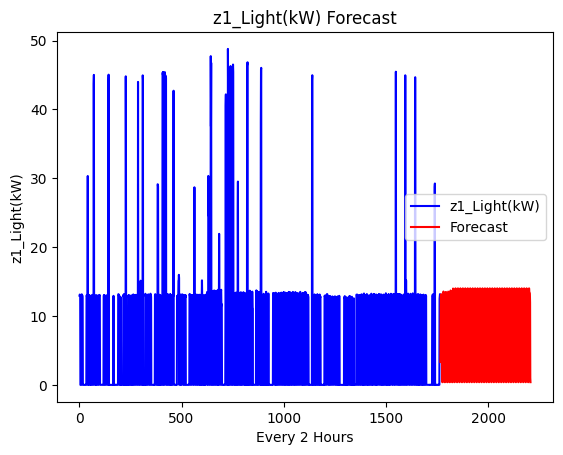

In [38]:
for column in all_forecasts:
  if column in ['z1_Light(kW)']:
    data[column] = data[column] * (max_min[column][0] - max_min[column][1]) + max_min[column][1]
    new_column = np.concatenate([data[column][:train_size], all_forecasts[column]])
    x = np.arange(1, len(new_column) + 1)

    split_point = len(new_column) - len(forecasts)

    plt.plot(x[:split_point], new_column[:split_point], label=f'{column}', color='blue')

    plt.plot(x[split_point:], new_column[split_point:], label='Forecast', color='red')

    plt.xlabel('Every 2 Hours')
    plt.ylabel(f'{column}')
    plt.title(f'{column} Forecast')

    plt.legend()

    plt.show()

In [49]:
for column in data:
  if column in ['z1_Light(kW)']:
    mse = np.mean((data[column][train_size:] - all_forecasts[column][:len(data[column][train_size:])]) ** 2)
    print(f'Mean Squared Error (MSE) of {column} per sample: {mse/test_size}')

Mean Squared Error (MSE) of z1_Light(kW) per sample: 0.31924680475304523
